1. Downlaod and split video in frames

In [1]:
# installing python packages for youtube video download
!pip install -q git+https://github.com/ytdl-org/youtube-dl.git
!pip install -q git+https://github.com/tragians/pafy.git@develop

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
# imports
import pafy
import cv2

In [3]:
# download video from provided url
URL = "https://www.youtube.com/watch?v=e_WBuBqS9h8"

video = pafy.new(URL)
best_quality_video = video.getbest()
best_quality_video.download()

'30 Minutes of Cars Driving By in 2009.mp4'

In [4]:
# rename .mp4 file
!mv "30 Minutes of Cars Driving By in 2009.mp4" "car_video.mp4"
# make dir to save split video
%mkdir car_images
# split video into frames
!ffmpeg -ss 00:00:00 -to 00:00:04 -i "car_video.mp4" car_images/%04d.png -hide_banner -loglevel error

2. Setup SAM mask predictor and helper functions

In [5]:
# adjusted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done


In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

#Utilise GPU for training/testing, if available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU Available: ", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("No GPU Available, Switching To CPU.")


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

GPU Available:  Tesla T4


In [7]:
# helper functions for visualization of SAM prediction
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=35):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def plot_tracked_mask(image, mask, frame_name):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_mask(mask, plt.gca())
  show_points(input_point, input_label, plt.gca())
  plt.title(f"Predicted mask for frame {frame_name}", fontsize=10)
  plt.axis('off')
  plt.show()

# helper function to isolate predicted mask with best score
def get_best_predicted_mask(masks, scores):
  best_score = 0.0

  for i, (mask, score) in enumerate(zip(masks, scores)):
    if score > best_score:
      best_score = score
      best_mask = mask

  return best_mask

3. Setup LoFTR matcher and helper functions

In [8]:
# adjusted from https://github.com/zju3dv/LoFTR/blob/master/notebooks/demo_single_pair.ipynb

!pip install  -q einops yacs kornia
!git clone -q https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

!mkdir weights
%cd weights/
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # downloading only checkpoint for outdoor-ds
%cd ..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 16.6 MB/s eta 0:00:00
/content/weights
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY
To: /content/weights/outdoor_ds.ckpt
100% 46.3M/46.3M [00:02<00:00, 19.2MB/s]
/content


In [9]:
from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

# initialize LoFTR matcher for matching between frames
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])

matcher = matcher.eval()
matcher.to(device);


In [10]:
from torchvision.ops import masks_to_boxes

################### Matcher helper function ##########################################################################################
# Returns single matched current frame point (in pixel coordinates) to use for segmentation with SAM
# the returned current frame point is the one matched to the past frame point that is closer to the center of the past predicted mask
# the center of the past predicted mask is estimated with the correspoding bounding box
######################################################################################################################################
def get_matched_point_for_current_frame(prev_mask, mkpts0, mkpts1):
  # convert previous frame SAM mask prediction to bounding box

  box = masks_to_boxes(torch.from_numpy(prev_mask).unsqueeze(0))[0]
  x_center = (box[2]-box[0])/2 + box[0]
  y_center = (box[3]-box[1])/2+box[1]

  # index of point obtained with LoFTR closer to box center in previous frame
  best_index = min(range(len(mkpts0)), key=lambda i: np.linalg.norm(mkpts0[i] - np.array([x_center.item(), y_center.item()])))

  # return corresponding input_point, input_label for segmantation with SAM in current frame
  input_point = np.array([mkpts1[best_index].astype(int)])
  input_label = np.array([1])

  return input_point, input_label

4. Start Tracking!

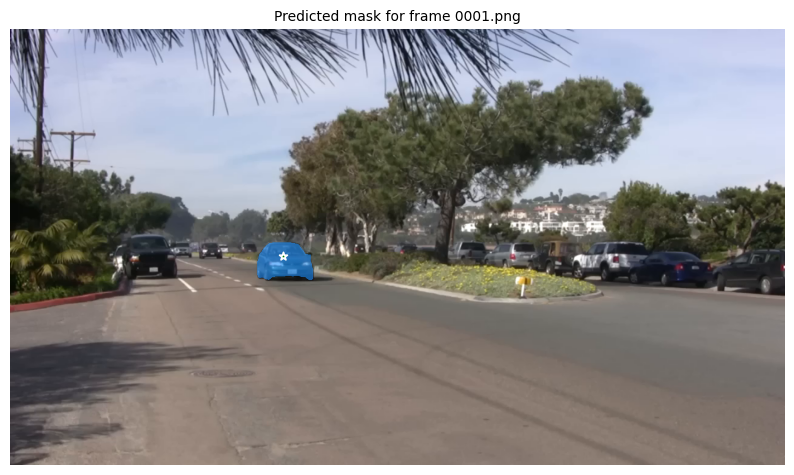

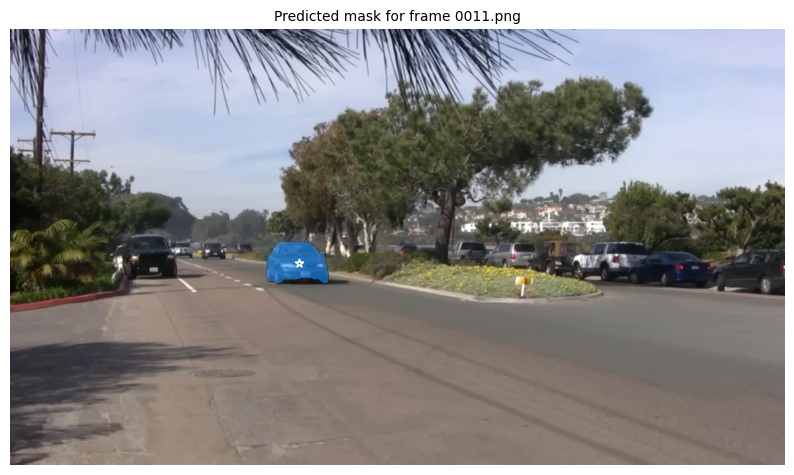

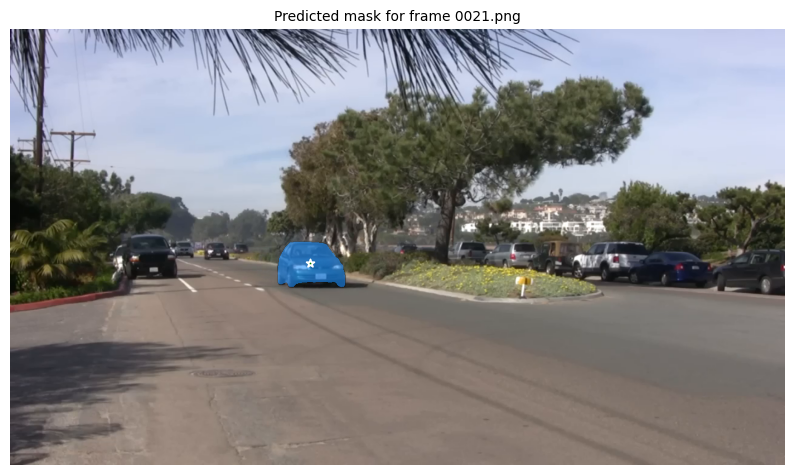

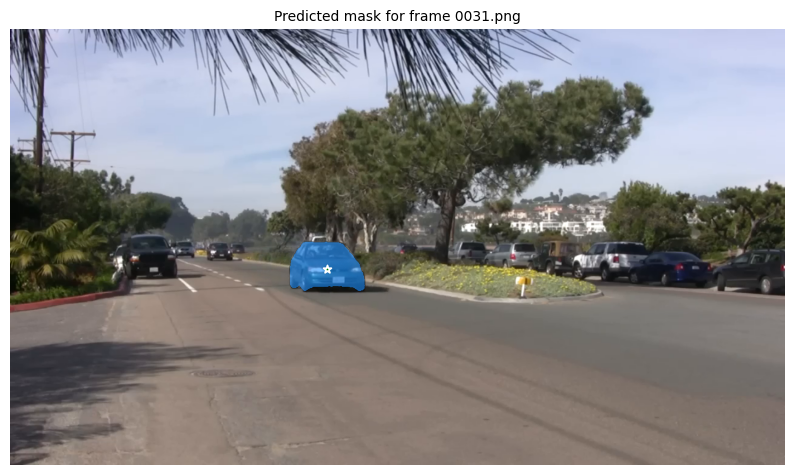

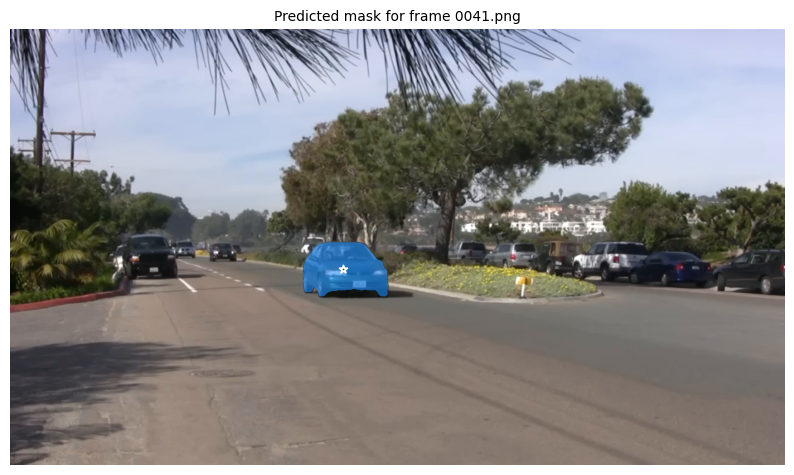

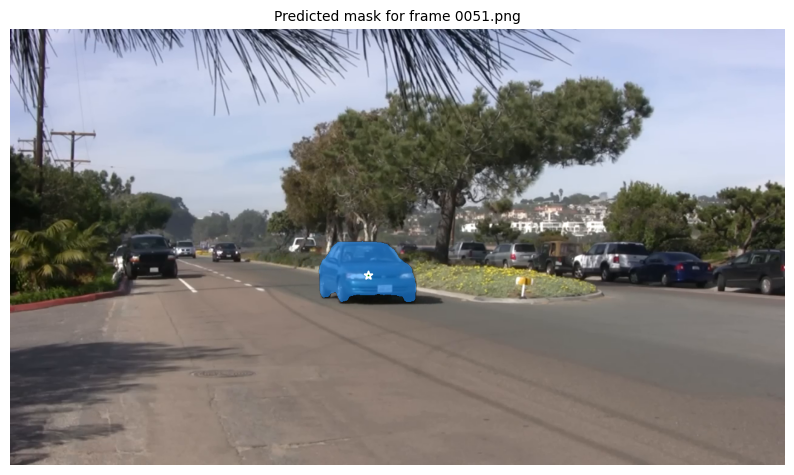

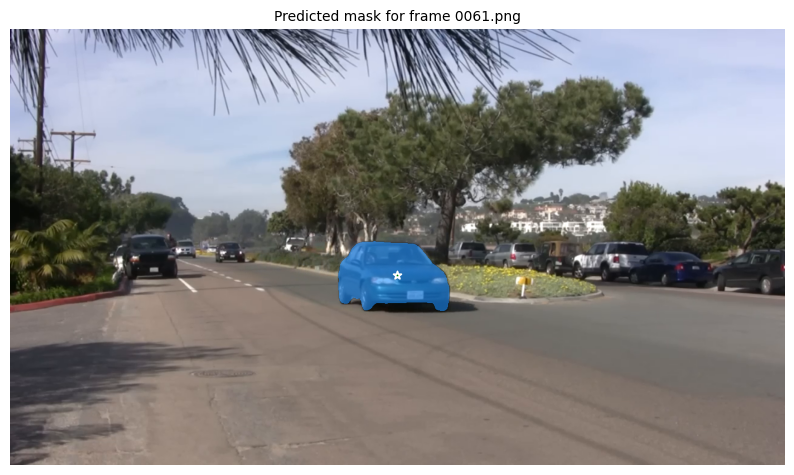

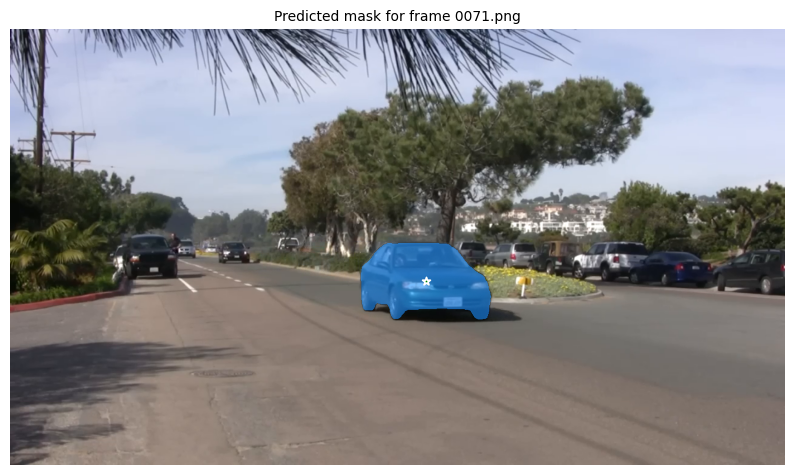

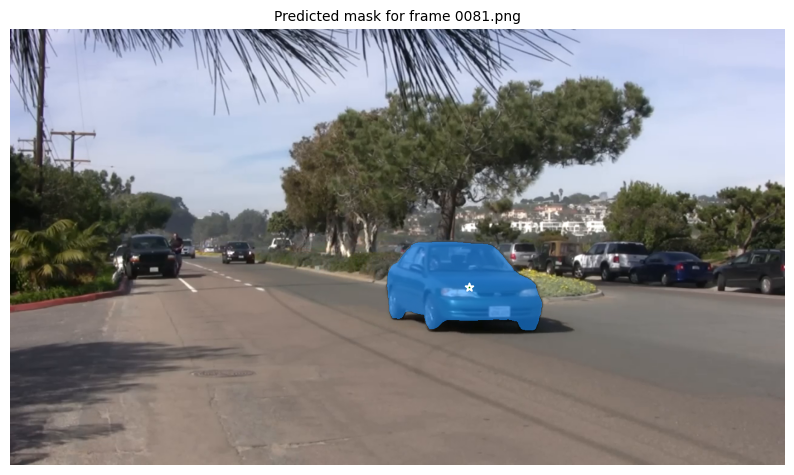

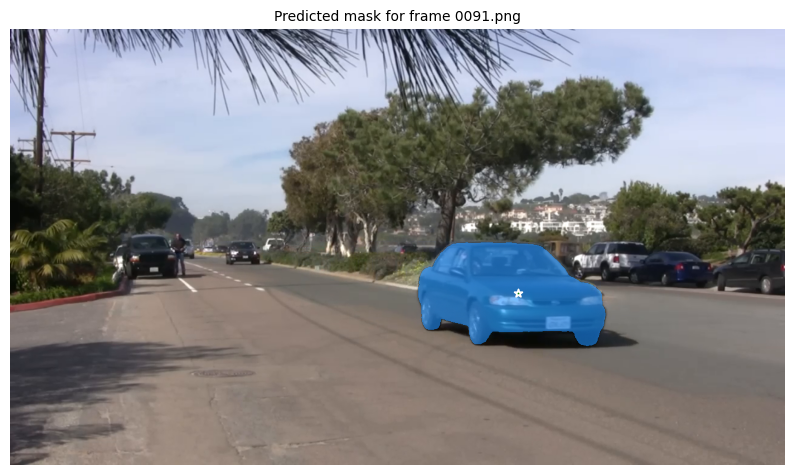

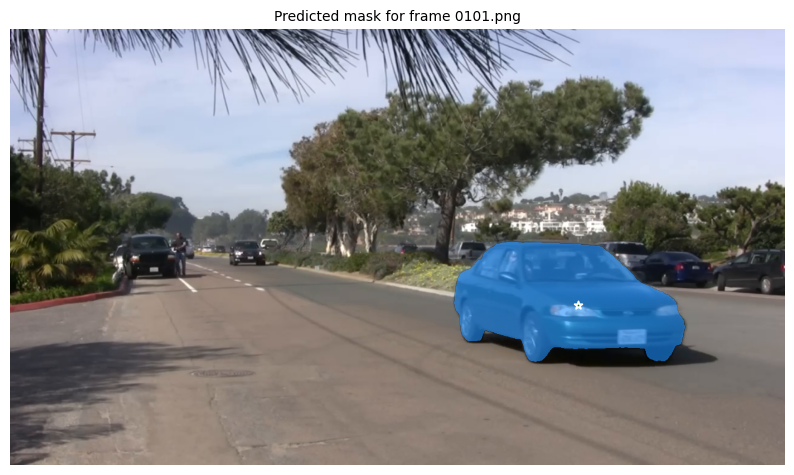

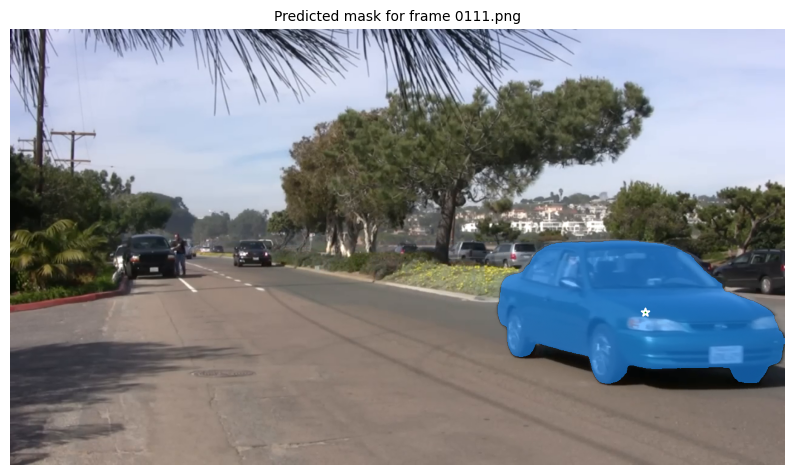

In [11]:
import os


img_dir = '/content/car_images/'
img_list = sorted(os.listdir(img_dir))

# Initialize previous and current image paths
# they are identical for frame #1 (img_list[0])
img_path = os.path.join(img_dir, img_list[0])
prev_img_path = img_path

# Manually initialize center of tracked object
WIDTH = 450
HEIGHT = 375
input_point = np.array([[WIDTH, HEIGHT]])
input_label = np.array([1])

# if SAMPLE_RATE  = 1 prediction takes place for all available frames
# In general a higher sampling rate makes tracking more challenging
SAMPLE_RATE = 10

# main loop for tracking!

for i, img in enumerate(img_list):

  if i%SAMPLE_RATE==0:
    if i!=0:
      # perform matching after the first frame only

      # read current and previous frame images in grayscale for matching with LoFTR
      img_path = os.path.join(img_dir, img_list[i])
      img0_raw = cv2.imread(prev_img_path, cv2.IMREAD_GRAYSCALE)
      img1_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      img0 = torch.from_numpy(img0_raw)[None][None].to(device)/ 255.
      img1 = torch.from_numpy(img1_raw)[None][None].to(device) / 255.
      batch = {'image0': img0, 'image1': img1}

      # Get all matched points between frames with LoFTR
      with torch.no_grad():
          matcher(batch)
          mkpts0 = batch['mkpts0_f'].cpu().numpy()
          mkpts1 = batch['mkpts1_f'].cpu().numpy()
          mconf = batch['mconf'].cpu().numpy()

      # isolate single matched point to perform segmentation with SAM in current frame
      input_point, input_label  = get_matched_point_for_current_frame(prev_mask=best_mask, mkpts0=mkpts0, mkpts1=mkpts1)

      prev_img_path = img_path

    # read current frame as rgb image for mask prediction with SAM
    img_rgb = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

    predictor.set_image(img_rgb)
    masks, scores , _ = predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)
    best_mask = get_best_predicted_mask(masks, scores)

    #plotting
    plot_tracked_mask(img_rgb,  best_mask, img_list[i])

